# Colorado Disaster Tweet Competition

From the contest problem description:  

"In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified."

In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout


train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print("Imports and file reads done.")

Imports and file reads done.


## EDA

In [84]:
print(train.head())
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


### Checking null values:

In [85]:
train.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [86]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### What do the tweets look like?

In [87]:
print("Five disaster tweets:")
for text in train.query("target==1").sample(n=5)["text"]: 
    print(text)

print("\nFive non-disaster tweets:")
for text in train.query("target==0").sample(n=5)["text"]: 
    print(text)

Five disaster tweets:
@eeenice221 true because of the truck that caught fire?
California man facing manslaughter charge in Sunday's wrong-way fatal crash in ... - http://t.co/1vz3RmjHy4: Ca... http://t.co/xevUEEfQBZ
When you go to a concert and someone screams in your ear... Does it look like I wanna loose my hearing anytime soon???
#Nuclear policy of #Japan without responsibility about Nuclear #Disaster will repeat same #failure.
#annonymous #guardian #NYTimes #Reuters
@kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?

Five non-disaster tweets:
Devastation: coming to a @Target and find the @Starbucks closed ?? #momneedscoffee #asap #iwontmakeit
Waking up sick with a rainstorm outside would usually make me sad. Not today though. Put some The Kooks on the stereo and let's do this.
@kakajambori ??
U control the future of india..
Yor Subject: Exploration or seismic Maintenance( Electrical or Mechanical)
@HGF52611 Uh huh. Yo

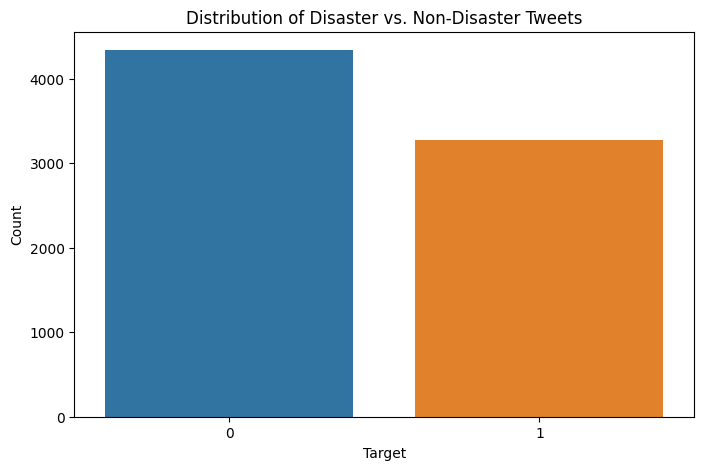

In [88]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=train)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## Let's apply some data cleaning

We will preprocess the text by removing stopwords, urls, html tags, punctuation

In [89]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)         # Remove HTML tags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Remove mentions
    text = re.sub(r'[^a-zA-Z]', ' ', text)    # Remove punctuation
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

train['clean_text'] = train['text'].apply(preprocess_text)
test['clean_text'] = test['text'].apply(preprocess_text)

print("Five disaster tweets after preprocessing:")
for text in train.query("target==1").sample(n=5)["clean_text"]: 
    print(text)

print("\nFive non-disaster tweets after preprocessing:")
for text in train.query("target==0").sample(n=5)["clean_text"]: 
    print(text)

Five disaster tweets after preprocessing:
thunderstorms little rain expected central california high fire danger weather cawx
wreckage conclusively confirmed mh malaysia pm investigators families
omg nixon lives richard nixon tricky dicky right picture hiding calgary
christian attacked muslims temple mount waving israeli flag via pamela geller
tomorrow going year since went panic concert dressed afycso ryan u guys remember

Five non-disaster tweets after preprocessing:
story
trouble understanding rotations within left leaning red black tree class currently learni
screamed got microchip needle tbh would cried needle massive ya haram
start big ass riot send jail today mfs shidddd
ben favorited


### How big is our vocabulary?

In [90]:
# Flatten all text, split into words, and find unique words
unique_words = set(word for text in train["clean_text"] for word in text.split())

# Count the number of unique words
unique_word_count = len(unique_words)

print(f"Number of unique words: {unique_word_count}")

# We will eliminate Hapax Legomena from tokenization
word_counts = Counter(word for text in train['clean_text'] for word in text.split())
vocab_size = len([word for word, count in word_counts.items() if count > 1])

print("Words used twice or more: " + str(vocab_size))

Number of unique words: 13884
Words used twice or more: 6142


### Let's tokenize the words:

In [91]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
X_test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

### Pad the sequences to the biggest tweet size: (max length will equal 23)

In [92]:
text_lengths = [len(text.split()) for text in train['clean_text']]
max_length = max(text_lengths)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Target variable
y_train = train['target'].values

### We will use Twitter GloVe for Embeddings

I'm not in a huge rush, so let's try the 100d version!

In [93]:
# Path to the Twitter GloVe file
glove_file_path = '/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt'  # Adjust the path and dimensions

# Load the embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # The word/token
        coefficients = np.asarray(values[1:], dtype='float32')  # Embedding vector
        embeddings_index[word] = coefficients

print(f"Loaded {len(embeddings_index)} word vectors from Twitter GloVe.")

embedding_dim = 100  # Match the dimension of the GloVe Twitter file

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

print(f"Created embedding matrix of shape {embedding_matrix.shape}.")

Loaded 1193514 word vectors from Twitter GloVe.
Created embedding matrix of shape (6142, 100).


# Set up our model.

I will use a bidirectional LSTM model.

In [94]:
model_bi_lstm = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),  # Freeze the embeddings
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

model_bi_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi_lstm.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │       614,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,200 (2.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 614,200 (2.34 MB)

In [95]:
X_train, X_val, y_train_split, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Stop when validation loss stops improving
    patience=3,          # Wait for 3 epochs before stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)

history = model_bi_lstm.fit(
    X_train,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.7301 - loss: 0.5316 - val_accuracy: 0.8043 - val_loss: 0.4484
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8061 - loss: 0.4281 - val_accuracy: 0.8135 - val_loss: 0.4260
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8031 - loss: 0.4308 - val_accuracy: 0.8096 - val_loss: 0.4254
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8214 - loss: 0.4019 - val_accuracy: 0.8188 - val_loss: 0.4176
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8330 - loss: 0.3912 - val_accuracy: 0.8129 - val_loss: 0.4192
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8288 - loss: 0.3749 - val_accuracy: 0.8188 - val_loss: 0.4250
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8440 - loss: 0.3599 - val_accuracy: 0.8109 - val_loss: 0.4414


# Evaluation

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8081 - loss: 0.4283


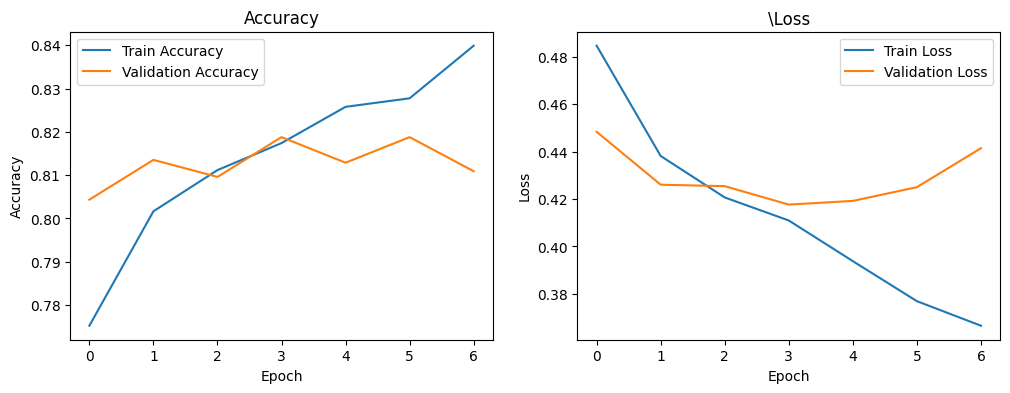

Validation Accuracy: 0.8188


In [96]:
val_loss, val_acc = model_bi_lstm.evaluate(X_val, y_val)

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('\Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(f"Validation Accuracy: {val_acc:.4f}")

# Alternate models

I tried a few different approaches at this point.  Here is the best I found: (BiLTSM with added layers at the end).

Note all of the things I tried here, including this one, were worse than my original model.


In [97]:
optimizer = Adam(learning_rate=0.0001)


model_bi_lstm_2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_bi_lstm_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_bi_lstm_2.fit(
    X_train,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5611 - loss: 0.6862 - val_accuracy: 0.5739 - val_loss: 0.6661
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5875 - loss: 0.6591 - val_accuracy: 0.7354 - val_loss: 0.5896
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7581 - loss: 0.5410 - val_accuracy: 0.7951 - val_loss: 0.4627
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8490 - loss: 0.3573 - val_accuracy: 0.7951 - val_loss: 0.4630
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8834 - loss: 0.2962 - val_accuracy: 0.7984 - val_loss: 0.4552


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7897 - loss: 0.4788


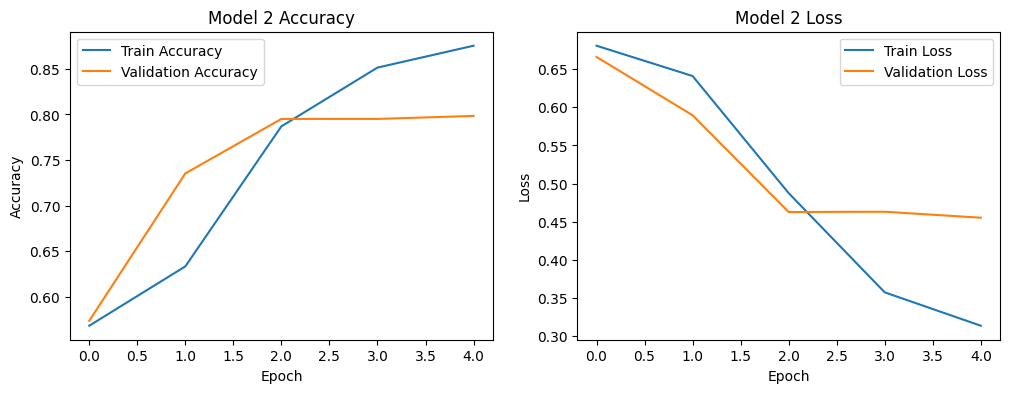

Model 2 Validation Accuracy: 0.7984


In [98]:
val_loss, val_acc = model_bi_lstm_2.evaluate(X_val, y_val)

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(f"Model 2 Validation Accuracy: {val_acc:.4f}")

# Let's make our predictions

We will use the first model to submit a solution to the contest.

In [99]:
test_preds = (model_bi_lstm.predict(X_test_padded) > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': test['id'], 'target': test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file created!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Submission file created!


# Conclusion

The first model, the standard bidirectional LTSM model, was the most successful.  It achieved a contest score of .80202, closely matching the validation accuracy I achieved of 0.8188

The variations I tried on the bidirectional LTSM model all had the same problem -- overfitting at about 78% validation accuracy after 2-3 epochs.  Adjusting training rate, adding L2, and adding different combinations of layers all resulted in close to the same overfitting point.

Comparing my project to similar projects using bidirectional LTSM, the choice to use the Twitter GloVe embeddings gave my model a slight edge over others who used the standard GloVe embeddings.